# CBF Data Exploration (Time Point 1)

## Graph Theory Exploration of TBI & Control Patients from BrainSport CBF Data Set 

Note: Examining only BN Atlas 264 ROIs, using Fisher's Z-value correlation values extracted in CONN Toolbox from processed rsfMRI images for all patients. 


## Table of Contents

<a href = #load>1. Load Data</a>

<a href = #sub1>2. Investigate Participant 1 in Detail and Design Augments</a>

<a href = #graphpipe>3. Graph Theory Pipeline</a>

<a href = #combine>4. Combine Graph Data For All Subjects</a>

<a href = #graph_hist>5. All Subject Graph Data Visualized</a>

TODO: t and p-vals for each graph theory measure b/t groups

NEXT QUARTER: ML Classifier!


In [272]:
import networkx as nx
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy
from scipy.io import loadmat

In [273]:
#allows pandas infinite rows and cols
pd.set_option('display.max_rows', 500)
pd.set_option('display.max_columns', 500)

<a id = 'load'></a>
## Load Data

In [274]:
#Load in weighted adjacency matrices for ROI-ROI correlations for each participant
data = loadmat('data/T1_Corrs.mat')

#Load in list of ROIs (corresponds to indices/columns in adjacency matrices)
ROIs = loadmat('data/T1_Rois.mat')

,conn.sub.num,cohort,mTBI,control.pooled,female,male
0,1,1,1,0,0,1
1,2,1,1,0,0,1
2,3,1,1,0,0,1
3,4,1,1,0,0,1
4,5,1,1,0,0,1
5,6,1,1,0,0,1
6,7,1,1,0,0,1
7,9,1,1,0,0,1
8,10,1,1,0,0,1
9,11,1,1,0,0,1


,conn.sub.num,cohort,mTBI,control.pooled,female,male
94,97,5,0,1,1,0
95,98,5,0,1,1,0
96,99,5,0,1,1,0
97,100,5,0,1,1,0
98,101,5,0,1,1,0
99,102,5,0,1,1,0
100,103,5,0,1,1,0
101,104,5,0,1,1,0
102,105,5,0,1,1,0
103,106,5,0,1,1,0


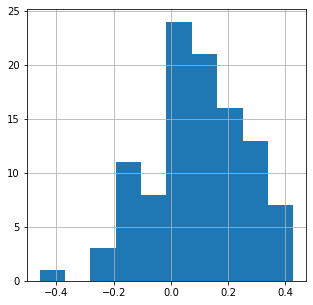

In [275]:
#load in covariates for grouping
covariates = pd.read_csv('data/Covariates_AllSubjects.csv')
covariates.head(15)

#grab only relevant columns
#could also grab control.insport and control.nc later
covariates = covariates[['conn.sub.num', 'cohort', 'mTBI', 'control.pooled', 'female', 'male', 'ses-1 fisher Z between BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial amygdala) and BN_Atlas_264_2mm_wkbrois.L_OrG_A11l (lateral area 11)']]

#clean up a bit
covariates.head(15)
covariates.rename(inplace = True, columns = {'ses-1 fisher Z between BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial amygdala) and BN_Atlas_264_2mm_wkbrois.L_OrG_A11l (lateral area 11)' : 'Ex ROI_Pair'})

#grab only patients which were present for T1
#covariates.info()
t1_covariates = covariates.dropna(inplace = False).copy()
#t1_covariates.info()

plt.rcParams['figure.figsize'] = 5,5
t1_covariates['Ex ROI_Pair'].hist()

#success!
#no longer need the ex ROI pair (just used to determine patients who did not complete their scan)
t1_covariates.drop(axis=1, inplace=True, labels = 'Ex ROI_Pair')
t1_covariates.reset_index(inplace=True, drop=True)

display(t1_covariates.head(10))
display(t1_covariates.tail(10))

Notably, even though I'm working with Fisher's Z Values, the example ROI pair I chose is not normally distributed/ centered around 0. Not important yet, but later it may be important that the dataset is notably imbalanced between TBI and non-TBI (fewer TBI). Will need to use some sort of oversampling/undersampling or utilize metrics which penalize classification errors across both groups treated as positive group. 

array([[<AxesSubplot:title={'center':'conn.sub.num'}>,
        <AxesSubplot:title={'center':'cohort'}>],
       [<AxesSubplot:title={'center':'mTBI'}>,
        <AxesSubplot:title={'center':'control.pooled'}>],
       [<AxesSubplot:title={'center':'female'}>,
        <AxesSubplot:title={'center':'male'}>]], dtype=object)

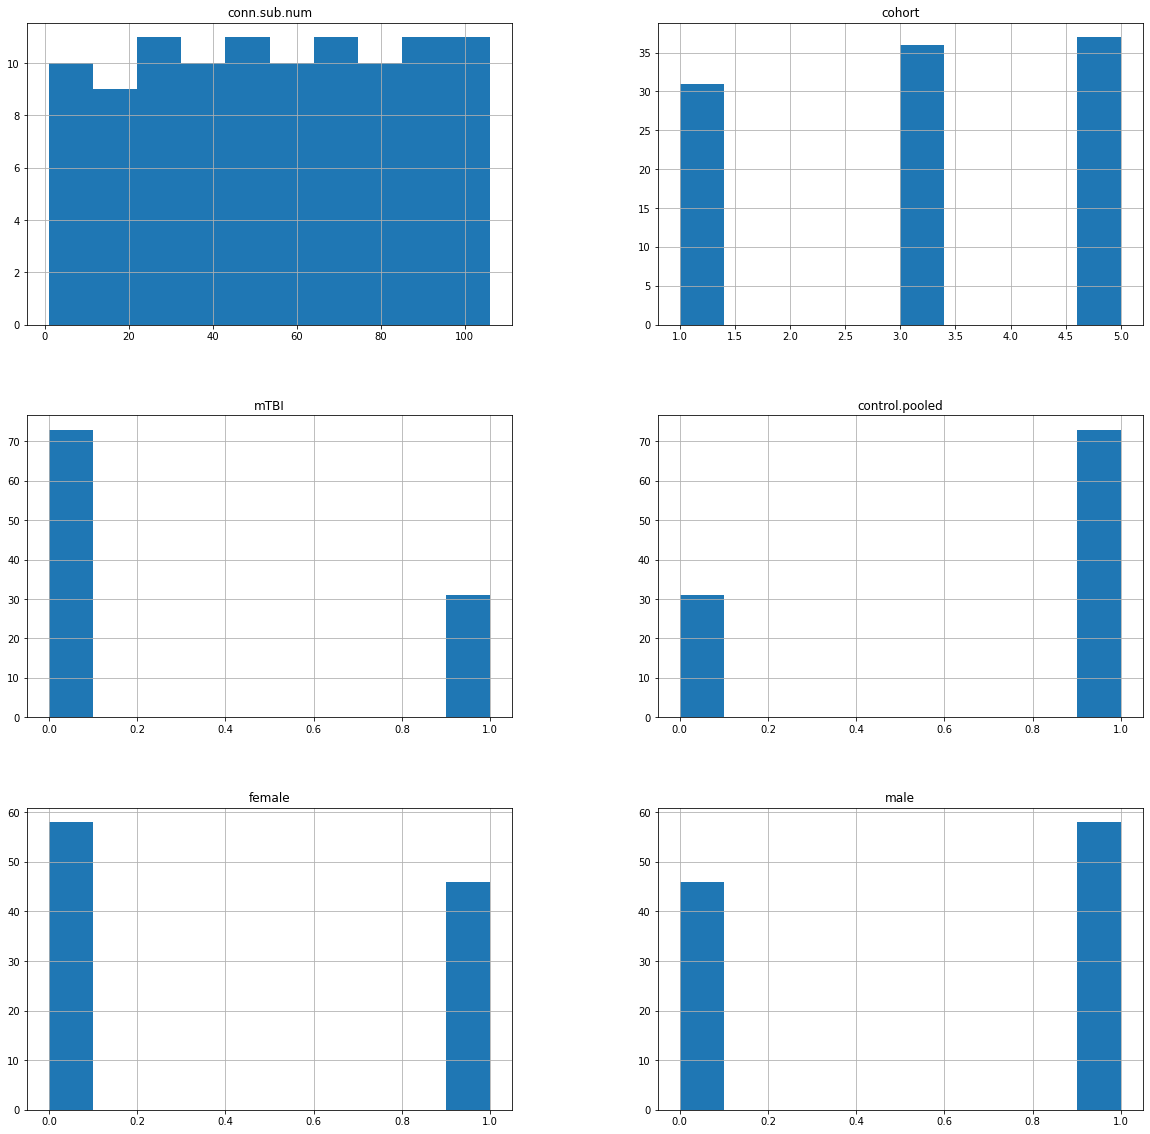

In [276]:
#make figure bigger
plt.rcParams['figure.figsize'] = 20,20

t1_covariates.hist()

In [277]:
ROIs.keys()

dict_keys(['__header__', '__version__', '__globals__', 'ROIS'])

In [278]:
%load_ext autoreload
%autoreload 2

import sys
#print(sys.path)
#sys.path.append('/Users/danielfrees/Desktop/brainSPORT_Code/TBI_Graph_Proj/scripts/')
from graph_scripts.Load_Data import load_mats


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [279]:
mats = load_mats(data, ROIs)

Shape of passed ROI-ROI matrix data is: (270, 270, 104)
Number of ROI indices passed is: (1, 270)
All matrices filtered for '264' labeled atlas ROIs only. Shape of each participant matrix is (264, 264).


In [317]:
display(mats[0].head(10))

,L_Amyg_mAmyg (medial amygdala),R_Amyg_mAmyg (medial amygdala),L_Amyg_lAmyg (lateral amygdala),R_Amyg_lAmyg (lateral amygdala),L_SFG_A8m (medial area 8),R_SFG_A8m (medial area 8),L_SFG_A8dl (dorsolateral area 8),R_SFG_A8dl (dorsolateral area 8),L_SFG_A9l (lateral area 9),R_SFG_A9l (lateral area 9),L_SFG_A6dl (dorsolateral area 6),R_SFG_A6dl (dorsolateral area 6),L_SFG_A6m (medial area 6),R_SFG_A6m (medial area 6),L_SFG_A9m (medial area 9),R_SFG_A9m (medial area 9),L_SFG_A10m (medial area 10),R_SFG_A10m (medial area 10),L_MFG_A9/46d (dorsal area 9/46),R_MFG_A9/46d (dorsal area 9/46),L_MFG_IFJ (inferior frontal junction),R_MFG_IFJ (inferior frontal junction),L_MFG_A46 (area 46),R_MFG_A46 (area 46),L_MFG_A9/46v (ventral area 9/46 ),R_MFG_A9/46v (ventral area 9/46 ),L_MFG_A8vl (ventrolateral area 8),R_MFG_A8vl (ventrolateral area 8),L_MFG_A6vl (ventrolateral area 6),R_MFG_A6vl (ventrolateral area 6),L_MFG_A10l (lateral area10),R_MFG_A10l (lateral area10),L_IFG_A44d (dorsal area 44),R_IFG_A44d (dorsal area 44),L_IFG_IFS (inferior frontal sulcus),R_IFG_IFS (inferior frontal sulcus),L_IFG_A45c (caudal area 45),R_IFG_A45c (caudal area 45),L_IFG_A45r (rostral area 45),R_IFG_A45r (rostral area 45),L_IFG_A44op (opercular area 44),R_IFG_A44op (opercular area 44),L_IFG_A44v (ventral area 44),R_IFG_A44v (ventral area 44),L_OrG_A14m (medial area 14),R_OrG_A14m (medial area 14),L_OrG_A12/47o (orbital area 12/47),R_OrG_A12/47o (orbital area 12/47),L_OrG_A11l (lateral area 11),R_OrG_A11l (lateral area 11),L_OrG_A11m (medial area 11),R_OrG_A11m (medial area 11),L_OrG_A13 (area 13),R_OrG_A13 (area 13),L_OrG_A12/47l (lateral area 12/47),R_OrG_A12/47l (lateral area 12/47),L_PrG_A4hf (area 4(head and face region)),R_PrG_A4hf (area 4(head and face region)),L_PrG_A6cdl (caudal dorsolateral area 6),R_PrG_A6cdl (caudal dorsolateral area 6),L_PrG_A4ul (area 4(upper limb region)),R_PrG_A4ul (area 4(upper limb region)),L_PrG_A4t (area 4(trunk region)),R_PrG_A4t (area 4(trunk region)),L_PrG_A4tl (area 4(tongue and larynx region)),R_PrG_A4tl (area 4(tongue and larynx region)),L_PrG_A6cvl (caudal ventrolateral area 6),R_PrG_A6cvl (caudal ventrolateral area 6),L_PCL_A1/2/3ll (area1/2/3 (lower limb region)),R_PCL_A1/2/3ll (area1/2/3 (lower limb region)),L_PCL_A4ll (area 4 (lower limb region)),R_PCL_A4ll (area 4 (lower limb region)),L_STG_A38m (medial area 38),R_STG_A38m (medial area 38),L_STG_A41/42 (area 41/42),R_STG_A41/42 (area 41/42),L_STG_TE1.0 and TE1.2 (TE1.0 and TE1.2),R_STG_TE1.0 and TE1.2 (TE1.0 and TE1.2),L_STG_A22c (caudal area 22),R_STG_A22c (caudal area 22),L_STG_A38l (lateral area 38),R_STG_A38l (lateral area 38),L_STG_A22r (rostral area 22),R_STG_A22r (rostral area 22),L_MTG_A21c (caudal area 21),R_MTG_A21c (caudal area 21),L_MTG_A21r (rostral area 21),R_MTG_A21r (rostral area 21),L_MTG_A37dl (dorsolateral area37),R_MTG_A37dl (dorsolateral area37),L_MTG_aSTS (anterior superior temporal sulcus),R_MTG_aSTS (anterior superior temporal sulcus),L_ITG_A20iv (intermediate ventral area 20),R_ITG_A20iv (intermediate ventral area 20),L_ITG_A37elv (extreme lateroventral area37),R_ITG_A37elv (extreme lateroventral area37),L_ITG_A20r (rostral area 20),R_ITG_A20r (rostral area 20),L_ITG_A20il (intermediate lateral area 20),R_ITG_A20il (intermediate lateral area 20),L_ITG_A37vl (ventrolateral area 37),R_ITG_A37vl (ventrolateral area 37),L_ITG_A20cl (caudolateral of area 20),R_ITG_A20cl (caudolateral of area 20),L_ITG_A20cv (caudoventral of area 20),R_ITG_A20cv (caudoventral of area 20),L_FuG_A20rv (rostroventral area 20),R_FuG_A20rv (rostroventral area 20),L_FuG_A37mv (medioventral area37),R_FuG_A37mv (medioventral area37),L_FuG_A37lv (lateroventral area37),R_FuG_A37lv (lateroventral area37),L_PhG_A35/36r (rostral area 35/36),R_PhG_A35/36r (rostral area 35/36),L_PhG_A35/36c (caudal area 35/36),R_PhG_A35/36c (caudal area 35/36),"L_PhG_TL (area TL (lateral PPHC, posterior parahippocampal gyrus))","R_PhG_TL (area TL (lateral PPHC, posterior parahippocampal gyrus)

In [281]:
def zero_negatives(val):
    if val<=0:
        val=0
    return val

In [282]:
def process_negative_corrs(mats, method = 'zero'):
    if method == 'zero':
        for i in range(len(mats)):
            mats[i] = mats[i].applymap(zero_negatives)
    return mats
        

In [283]:
mats = process_negative_corrs(mats)
mats[0].head(15)

,BN_Atlas_264_2mm_wkbrois.L_Amyg_mAmyg (medial amygdala),BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial amygdala),BN_Atlas_264_2mm_wkbrois.L_Amyg_lAmyg (lateral amygdala),BN_Atlas_264_2mm_wkbrois.R_Amyg_lAmyg (lateral amygdala),BN_Atlas_264_2mm_wkbrois.L_SFG_A8m (medial area 8),BN_Atlas_264_2mm_wkbrois.R_SFG_A8m (medial area 8),BN_Atlas_264_2mm_wkbrois.L_SFG_A8dl (dorsolateral area 8),BN_Atlas_264_2mm_wkbrois.R_SFG_A8dl (dorsolateral area 8),BN_Atlas_264_2mm_wkbrois.L_SFG_A9l (lateral area 9),BN_Atlas_264_2mm_wkbrois.R_SFG_A9l (lateral area 9),BN_Atlas_264_2mm_wkbrois.L_SFG_A6dl (dorsolateral area 6),BN_Atlas_264_2mm_wkbrois.R_SFG_A6dl (dorsolateral area 6),BN_Atlas_264_2mm_wkbrois.L_SFG_A6m (medial area 6),BN_Atlas_264_2mm_wkbrois.R_SFG_A6m (medial area 6),BN_Atlas_264_2mm_wkbrois.L_SFG_A9m (medial area 9),BN_Atlas_264_2mm_wkbrois.R_SFG_A9m (medial area 9),BN_Atlas_264_2mm_wkbrois.L_SFG_A10m (medial area 10),BN_Atlas_264_2mm_wkbrois.R_SFG_A10m (medial area 10),BN_Atlas_264_2mm_wkbrois.L_MFG_A9/46d (dorsal area 9/46),BN_Atlas_264_2mm_wkbrois.R_MFG_A9/46d (dorsal area 9/46),BN_Atlas_264_2mm_wkbrois.L_MFG_IFJ (inferior frontal junction),BN_Atlas_264_2mm_wkbrois.R_MFG_IFJ (inferior frontal junction),BN_Atlas_264_2mm_wkbrois.L_MFG_A46 (area 46),BN_Atlas_264_2mm_wkbrois.R_MFG_A46 (area 46),BN_Atlas_264_2mm_wkbrois.L_MFG_A9/46v (ventral area 9/46 ),BN_Atlas_264_2mm_wkbrois.R_MFG_A9/46v (ventral area 9/46 ),BN_Atlas_264_2mm_wkbrois.L_MFG_A8vl (ventrolateral area 8),BN_Atlas_264_2mm_wkbrois.R_MFG_A8vl (ventrolateral area 8),BN_Atlas_264_2mm_wkbrois.L_MFG_A6vl (ventrolateral area 6),BN_Atlas_264_2mm_wkbrois.R_MFG_A6vl (ventrolateral area 6),BN_Atlas_264_2mm_wkbrois.L_MFG_A10l (lateral area10),BN_Atlas_264_2mm_wkbrois.R_MFG_A10l (lateral area10),BN_Atlas_264_2mm_wkbrois.L_IFG_A44d (dorsal area 44),BN_Atlas_264_2mm_wkbrois.R_IFG_A44d (dorsal area 44),BN_Atlas_264_2mm_wkbrois.L_IFG_IFS (inferior frontal sulcus),BN_Atlas_264_2mm_wkbrois.R_IFG_IFS (inferior frontal sulcus),BN_Atlas_264_2mm_wkbrois.L_IFG_A45c (caudal area 45),BN_Atlas_264_2mm_wkbrois.R_IFG_A45c (caudal area 45),BN_Atlas_264_2mm_wkbrois.L_IFG_A45r (rostral area 45),BN_Atlas_264_2mm_wkbrois.R_IFG_A45r (rostral area 45),BN_Atlas_264_2mm_wkbrois.L_IFG_A44op (opercular area 44),BN_Atlas_264_2mm_wkbrois.R_IFG_A44op (opercular area 44),BN_Atlas_264_2mm_wkbrois.L_IFG_A44v (ventral area 44),BN_Atlas_264_2mm_wkbrois.R_IFG_A44v (ventral area 44),BN_Atlas_264_2mm_wkbrois.L_OrG_A14m (medial area 14),BN_Atlas_264_2mm_wkbrois.R_OrG_A14m (medial area 14),BN_Atlas_264_2mm_wkbrois.L_OrG_A12/47o (orbital area 12/47),BN_Atlas_264_2mm_wkbrois.R_OrG_A12/47o (orbital area 12/47),BN_Atlas_264_2mm_wkbrois.L_OrG_A11l (lateral area 11),BN_Atlas_264_2mm_wkbrois.R_OrG_A11l (lateral area 11),BN_Atlas_264_2mm_wkbrois.L_OrG_A11m (medial area 11),BN_Atlas_264_2mm_wkbrois.R_OrG_A11m (medial area 11),BN_Atlas_264_2mm_wkbrois.L_OrG_A13 (area 13),BN_Atlas_264_2mm_wkbrois.R_OrG_A13 (area 13),BN_Atlas_264_2mm_wkbrois.L_OrG_A12/47l (lateral area 12/47),BN_Atlas_264_2mm_wkbrois.R_OrG_A12/47l (lateral area 12/47),BN_Atlas_264_2mm_wkbrois.L_PrG_A4hf (area 4(head and face region)),BN_Atlas_264_2mm_wkbrois.R_PrG_A4hf (area 4(head and face region)),BN_Atlas_264_2mm_wkbrois.L_PrG_A6cdl (caudal dorsolateral area 6),BN_Atlas_264_2mm_wkbrois.R_PrG_A6cdl (caudal dorsolateral area 6),BN_Atlas_264_2mm_wkbrois.L_PrG_A4ul (area 4(upper limb region)),BN_Atlas_264_2mm_wkbrois.R_PrG_A4ul (area 4(upper limb region)),BN_Atlas_264_2mm_wkbrois.L_PrG_A4t (area 4(trunk region)),BN_Atlas_264_2mm_wkbrois.R_PrG_A4t (area 4(trunk region)),BN_Atlas_264_2mm_wkbrois.L_PrG_A4tl (area 4(tongue and larynx region)),BN_Atlas_264_2mm_wkbrois.R_PrG_A4tl (area 4(tongue and larynx region)),BN_Atlas_264_2mm_wkbrois.L_PrG_A6cvl (caudal ventrolateral area 6),BN_Atlas_264_2mm_wkbrois.R_PrG_A6cvl (caudal ventrolateral area 6),BN_Atlas_264_2mm_wkbrois.L_PCL_A1/2/3ll (area1/2/3 (lower limb region)),BN_Atlas_264_2mm_wkbrois.R_PCL_A1/2/3ll (area1/2/3 (lower limb 

In [284]:
def pass_through_cutoff(val, cutoff):
    if val <= cutoff:
        val = 0
    return val

In [285]:
def dynamic_threshold(mat, percentile = 75):
    '''Dynamically threshold Fisher's Z values so that only the specified 
    percentile and up of correlation values are retained. This gives all graphs a density of 
    1-percentile.

    Expects a matrix with negative correlations already removed. Supported by current rsfMRI GT Literature.'''
    arr = mat.values
    cutoff = np.percentile(arr, 75)
    for col in mat.columns:
        mat[col] = mat[col].apply(pass_through_cutoff, args = [cutoff])
    return mat

In [286]:
def threshold_all_mats(mats, percentile):
    for i in range(len(mats)):
        mats[i] = dynamic_threshold(mats[i], percentile)
    return mats

In [287]:
mats = threshold_all_mats(mats, 75)

In [288]:
mats[0].head(10)

,BN_Atlas_264_2mm_wkbrois.L_Amyg_mAmyg (medial amygdala),BN_Atlas_264_2mm_wkbrois.R_Amyg_mAmyg (medial amygdala),BN_Atlas_264_2mm_wkbrois.L_Amyg_lAmyg (lateral amygdala),BN_Atlas_264_2mm_wkbrois.R_Amyg_lAmyg (lateral amygdala),BN_Atlas_264_2mm_wkbrois.L_SFG_A8m (medial area 8),BN_Atlas_264_2mm_wkbrois.R_SFG_A8m (medial area 8),BN_Atlas_264_2mm_wkbrois.L_SFG_A8dl (dorsolateral area 8),BN_Atlas_264_2mm_wkbrois.R_SFG_A8dl (dorsolateral area 8),BN_Atlas_264_2mm_wkbrois.L_SFG_A9l (lateral area 9),BN_Atlas_264_2mm_wkbrois.R_SFG_A9l (lateral area 9),BN_Atlas_264_2mm_wkbrois.L_SFG_A6dl (dorsolateral area 6),BN_Atlas_264_2mm_wkbrois.R_SFG_A6dl (dorsolateral area 6),BN_Atlas_264_2mm_wkbrois.L_SFG_A6m (medial area 6),BN_Atlas_264_2mm_wkbrois.R_SFG_A6m (medial area 6),BN_Atlas_264_2mm_wkbrois.L_SFG_A9m (medial area 9),BN_Atlas_264_2mm_wkbrois.R_SFG_A9m (medial area 9),BN_Atlas_264_2mm_wkbrois.L_SFG_A10m (medial area 10),BN_Atlas_264_2mm_wkbrois.R_SFG_A10m (medial area 10),BN_Atlas_264_2mm_wkbrois.L_MFG_A9/46d (dorsal area 9/46),BN_Atlas_264_2mm_wkbrois.R_MFG_A9/46d (dorsal area 9/46),BN_Atlas_264_2mm_wkbrois.L_MFG_IFJ (inferior frontal junction),BN_Atlas_264_2mm_wkbrois.R_MFG_IFJ (inferior frontal junction),BN_Atlas_264_2mm_wkbrois.L_MFG_A46 (area 46),BN_Atlas_264_2mm_wkbrois.R_MFG_A46 (area 46),BN_Atlas_264_2mm_wkbrois.L_MFG_A9/46v (ventral area 9/46 ),BN_Atlas_264_2mm_wkbrois.R_MFG_A9/46v (ventral area 9/46 ),BN_Atlas_264_2mm_wkbrois.L_MFG_A8vl (ventrolateral area 8),BN_Atlas_264_2mm_wkbrois.R_MFG_A8vl (ventrolateral area 8),BN_Atlas_264_2mm_wkbrois.L_MFG_A6vl (ventrolateral area 6),BN_Atlas_264_2mm_wkbrois.R_MFG_A6vl (ventrolateral area 6),BN_Atlas_264_2mm_wkbrois.L_MFG_A10l (lateral area10),BN_Atlas_264_2mm_wkbrois.R_MFG_A10l (lateral area10),BN_Atlas_264_2mm_wkbrois.L_IFG_A44d (dorsal area 44),BN_Atlas_264_2mm_wkbrois.R_IFG_A44d (dorsal area 44),BN_Atlas_264_2mm_wkbrois.L_IFG_IFS (inferior frontal sulcus),BN_Atlas_264_2mm_wkbrois.R_IFG_IFS (inferior frontal sulcus),BN_Atlas_264_2mm_wkbrois.L_IFG_A45c (caudal area 45),BN_Atlas_264_2mm_wkbrois.R_IFG_A45c (caudal area 45),BN_Atlas_264_2mm_wkbrois.L_IFG_A45r (rostral area 45),BN_Atlas_264_2mm_wkbrois.R_IFG_A45r (rostral area 45),BN_Atlas_264_2mm_wkbrois.L_IFG_A44op (opercular area 44),BN_Atlas_264_2mm_wkbrois.R_IFG_A44op (opercular area 44),BN_Atlas_264_2mm_wkbrois.L_IFG_A44v (ventral area 44),BN_Atlas_264_2mm_wkbrois.R_IFG_A44v (ventral area 44),BN_Atlas_264_2mm_wkbrois.L_OrG_A14m (medial area 14),BN_Atlas_264_2mm_wkbrois.R_OrG_A14m (medial area 14),BN_Atlas_264_2mm_wkbrois.L_OrG_A12/47o (orbital area 12/47),BN_Atlas_264_2mm_wkbrois.R_OrG_A12/47o (orbital area 12/47),BN_Atlas_264_2mm_wkbrois.L_OrG_A11l (lateral area 11),BN_Atlas_264_2mm_wkbrois.R_OrG_A11l (lateral area 11),BN_Atlas_264_2mm_wkbrois.L_OrG_A11m (medial area 11),BN_Atlas_264_2mm_wkbrois.R_OrG_A11m (medial area 11),BN_Atlas_264_2mm_wkbrois.L_OrG_A13 (area 13),BN_Atlas_264_2mm_wkbrois.R_OrG_A13 (area 13),BN_Atlas_264_2mm_wkbrois.L_OrG_A12/47l (lateral area 12/47),BN_Atlas_264_2mm_wkbrois.R_OrG_A12/47l (lateral area 12/47),BN_Atlas_264_2mm_wkbrois.L_PrG_A4hf (area 4(head and face region)),BN_Atlas_264_2mm_wkbrois.R_PrG_A4hf (area 4(head and face region)),BN_Atlas_264_2mm_wkbrois.L_PrG_A6cdl (caudal dorsolateral area 6),BN_Atlas_264_2mm_wkbrois.R_PrG_A6cdl (caudal dorsolateral area 6),BN_Atlas_264_2mm_wkbrois.L_PrG_A4ul (area 4(upper limb region)),BN_Atlas_264_2mm_wkbrois.R_PrG_A4ul (area 4(upper limb region)),BN_Atlas_264_2mm_wkbrois.L_PrG_A4t (area 4(trunk region)),BN_Atlas_264_2mm_wkbrois.R_PrG_A4t (area 4(trunk region)),BN_Atlas_264_2mm_wkbrois.L_PrG_A4tl (area 4(tongue and larynx region)),BN_Atlas_264_2mm_wkbrois.R_PrG_A4tl (area 4(tongue and larynx region)),BN_Atlas_264_2mm_wkbrois.L_PrG_A6cvl (caudal ventrolateral area 6),BN_Atlas_264_2mm_wkbrois.R_PrG_A6cvl (caudal ventrolateral area 6),BN_Atlas_264_2mm_wkbrois.L_PCL_A1/2/3ll (area1/2/3 (lower limb region)),BN_Atlas_264_2mm_wkbrois.R_PCL_A1/2/3ll (area1/2/3 (lower limb 

In [289]:
def remove_atlas(str):
    str = str.replace('BN_Atlas_264_2mm_wkbrois.', '')
    return str

#Clean up ROI names
def clean_roi_names(mats):
    for i in range(len(mats)):
        mats[i] = mats[i].rename(remove_atlas, axis=1)
        mats[i] = mats[i].rename(remove_atlas, axis=0)
    return mats

In [290]:
mats = clean_roi_names(mats)
mats[0].head()

,L_Amyg_mAmyg (medial amygdala),R_Amyg_mAmyg (medial amygdala),L_Amyg_lAmyg (lateral amygdala),R_Amyg_lAmyg (lateral amygdala),L_SFG_A8m (medial area 8),R_SFG_A8m (medial area 8),L_SFG_A8dl (dorsolateral area 8),R_SFG_A8dl (dorsolateral area 8),L_SFG_A9l (lateral area 9),R_SFG_A9l (lateral area 9),L_SFG_A6dl (dorsolateral area 6),R_SFG_A6dl (dorsolateral area 6),L_SFG_A6m (medial area 6),R_SFG_A6m (medial area 6),L_SFG_A9m (medial area 9),R_SFG_A9m (medial area 9),L_SFG_A10m (medial area 10),R_SFG_A10m (medial area 10),L_MFG_A9/46d (dorsal area 9/46),R_MFG_A9/46d (dorsal area 9/46),L_MFG_IFJ (inferior frontal junction),R_MFG_IFJ (inferior frontal junction),L_MFG_A46 (area 46),R_MFG_A46 (area 46),L_MFG_A9/46v (ventral area 9/46 ),R_MFG_A9/46v (ventral area 9/46 ),L_MFG_A8vl (ventrolateral area 8),R_MFG_A8vl (ventrolateral area 8),L_MFG_A6vl (ventrolateral area 6),R_MFG_A6vl (ventrolateral area 6),L_MFG_A10l (lateral area10),R_MFG_A10l (lateral area10),L_IFG_A44d (dorsal area 44),R_IFG_A44d (dorsal area 44),L_IFG_IFS (inferior frontal sulcus),R_IFG_IFS (inferior frontal sulcus),L_IFG_A45c (caudal area 45),R_IFG_A45c (caudal area 45),L_IFG_A45r (rostral area 45),R_IFG_A45r (rostral area 45),L_IFG_A44op (opercular area 44),R_IFG_A44op (opercular area 44),L_IFG_A44v (ventral area 44),R_IFG_A44v (ventral area 44),L_OrG_A14m (medial area 14),R_OrG_A14m (medial area 14),L_OrG_A12/47o (orbital area 12/47),R_OrG_A12/47o (orbital area 12/47),L_OrG_A11l (lateral area 11),R_OrG_A11l (lateral area 11),L_OrG_A11m (medial area 11),R_OrG_A11m (medial area 11),L_OrG_A13 (area 13),R_OrG_A13 (area 13),L_OrG_A12/47l (lateral area 12/47),R_OrG_A12/47l (lateral area 12/47),L_PrG_A4hf (area 4(head and face region)),R_PrG_A4hf (area 4(head and face region)),L_PrG_A6cdl (caudal dorsolateral area 6),R_PrG_A6cdl (caudal dorsolateral area 6),L_PrG_A4ul (area 4(upper limb region)),R_PrG_A4ul (area 4(upper limb region)),L_PrG_A4t (area 4(trunk region)),R_PrG_A4t (area 4(trunk region)),L_PrG_A4tl (area 4(tongue and larynx region)),R_PrG_A4tl (area 4(tongue and larynx region)),L_PrG_A6cvl (caudal ventrolateral area 6),R_PrG_A6cvl (caudal ventrolateral area 6),L_PCL_A1/2/3ll (area1/2/3 (lower limb region)),R_PCL_A1/2/3ll (area1/2/3 (lower limb region)),L_PCL_A4ll (area 4 (lower limb region)),R_PCL_A4ll (area 4 (lower limb region)),L_STG_A38m (medial area 38),R_STG_A38m (medial area 38),L_STG_A41/42 (area 41/42),R_STG_A41/42 (area 41/42),L_STG_TE1.0 and TE1.2 (TE1.0 and TE1.2),R_STG_TE1.0 and TE1.2 (TE1.0 and TE1.2),L_STG_A22c (caudal area 22),R_STG_A22c (caudal area 22),L_STG_A38l (lateral area 38),R_STG_A38l (lateral area 38),L_STG_A22r (rostral area 22),R_STG_A22r (rostral area 22),L_MTG_A21c (caudal area 21),R_MTG_A21c (caudal area 21),L_MTG_A21r (rostral area 21),R_MTG_A21r (rostral area 21),L_MTG_A37dl (dorsolateral area37),R_MTG_A37dl (dorsolateral area37),L_MTG_aSTS (anterior superior temporal sulcus),R_MTG_aSTS (anterior superior temporal sulcus),L_ITG_A20iv (intermediate ventral area 20),R_ITG_A20iv (intermediate ventral area 20),L_ITG_A37elv (extreme lateroventral area37),R_ITG_A37elv (extreme lateroventral area37),L_ITG_A20r (rostral area 20),R_ITG_A20r (rostral area 20),L_ITG_A20il (intermediate lateral area 20),R_ITG_A20il (intermediate lateral area 20),L_ITG_A37vl (ventrolateral area 37),R_ITG_A37vl (ventrolateral area 37),L_ITG_A20cl (caudolateral of area 20),R_ITG_A20cl (caudolateral of area 20),L_ITG_A20cv (caudoventral of area 20),R_ITG_A20cv (caudoventral of area 20),L_FuG_A20rv (rostroventral area 20),R_FuG_A20rv (rostroventral area 20),L_FuG_A37mv (medioventral area37),R_FuG_A37mv (medioventral area37),L_FuG_A37lv (lateroventral area37),R_FuG_A37lv (lateroventral area37),L_PhG_A35/36r (rostral area 35/36),R_PhG_A35/36r (rostral area 35/36),L_PhG_A35/36c (caudal area 35/36),R_PhG_A35/36c (caudal area 35/36),"L_PhG_TL (area TL (lateral PPHC, posterior parahippocampal gyrus))","R_PhG_TL (area TL (lateral PPHC, posterior parahippocampal gyrus)

<a id = 'sub1'></a>
# Investigate Subject 1 In Detail & Design Graph Theoretical Augment Pipeline

Avg Clustering: 0.08309838360228662


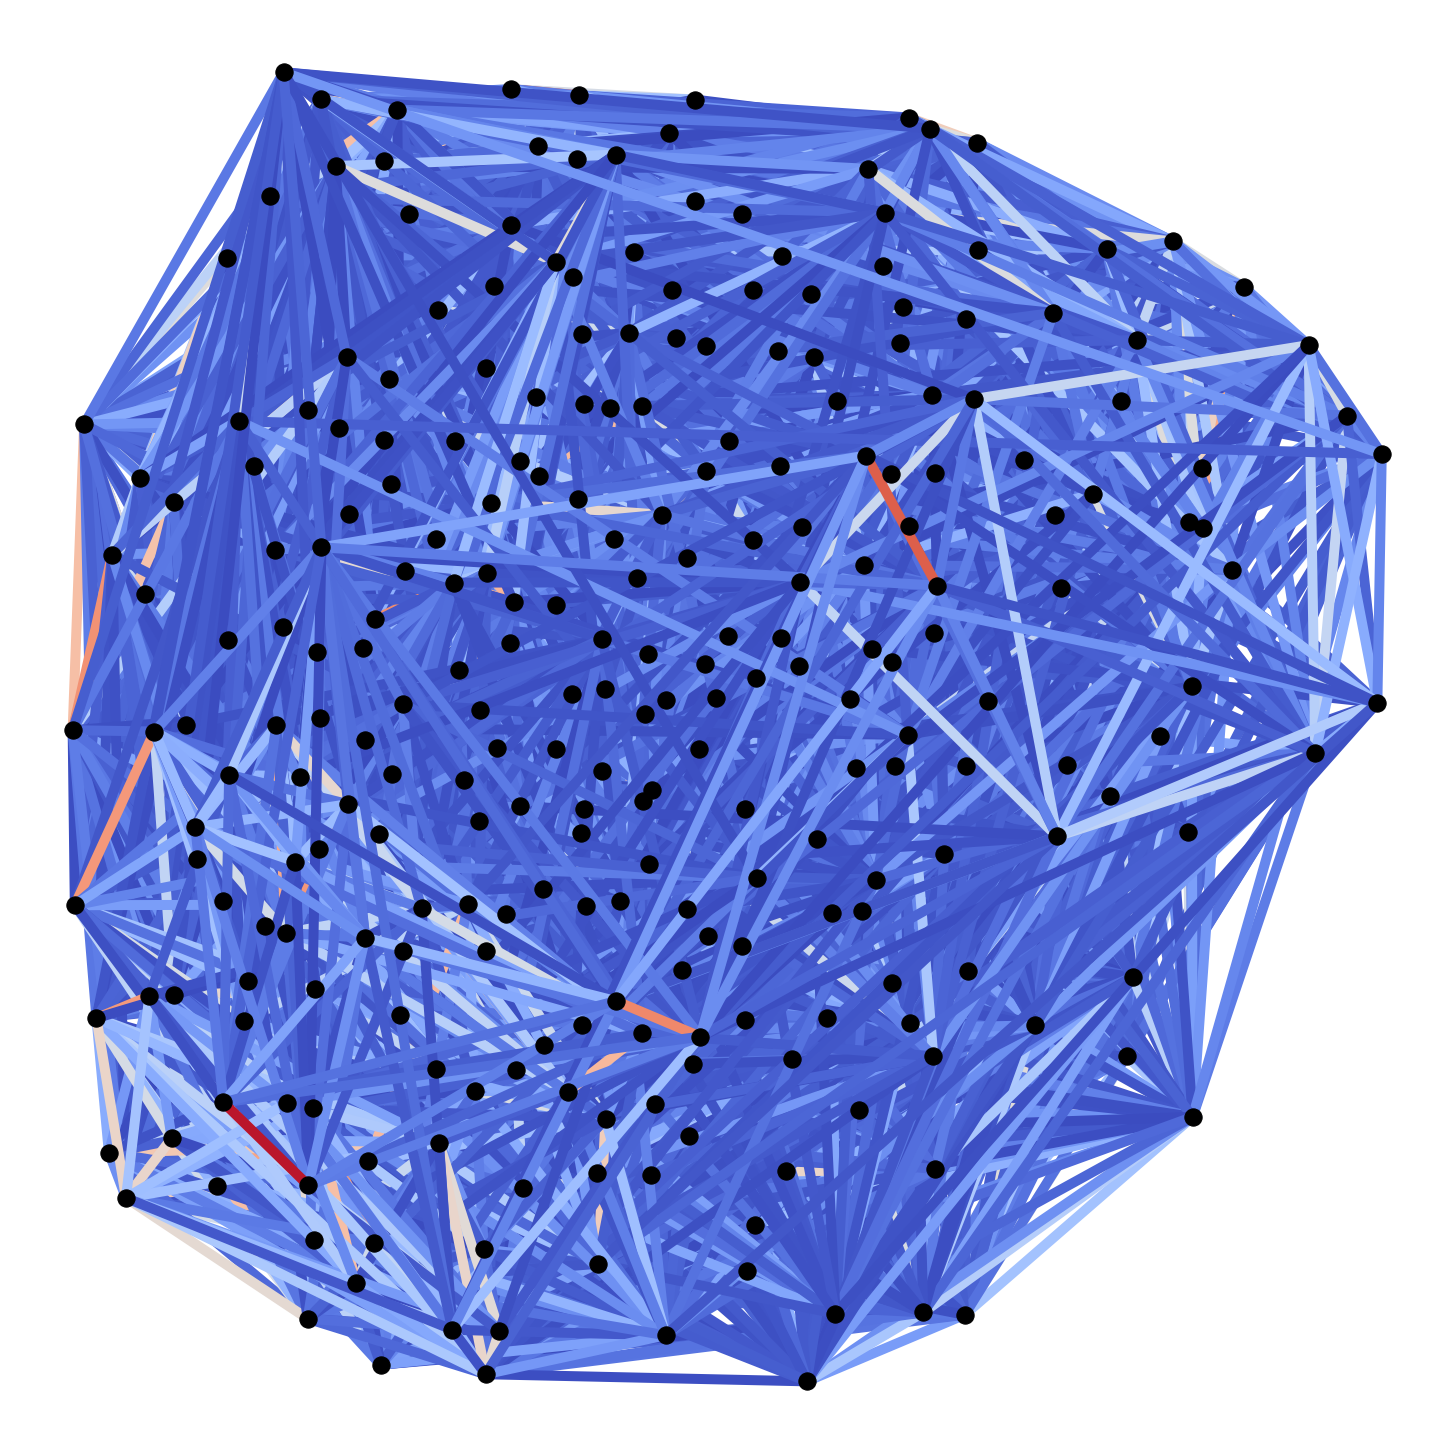

In [291]:
#Investigate participant 1 in detail

p1 = nx.from_pandas_adjacency(mats[0])
p1.name = 'participant_1'

edges,weights = zip(*nx.get_edge_attributes(p1,'weight').items())
pos = nx.spring_layout(p1)
nx.draw(p1, pos, node_color='black', edgelist=edges, edge_color=weights, width=10.0, edge_cmap=plt.cm.coolwarm)

print("Avg Clustering: " + str(nx.average_clustering(p1, weight = 'weight')))



In [292]:
#unhash to see node names (they match the ROIs given)
#p1.nodes

In [293]:
#TODO: Not working at the moment + Too computationally expensive

#from networkx, I modified for weighted shortest paths -> weighted global efficiency
def global_efficiency(G):
    """Returns the average global efficiency of the graph.

    The *efficiency* of a pair of nodes in a graph is the multiplicative
    inverse of the shortest path distance between the nodes. The *average
    global efficiency* of a graph is the average efficiency of all pairs of
    nodes [1]_.

    """
    n = len(G)
    denom = n * (n - 1)
    if denom != 0:
        lengths = nx.all_pairs_shortest_path_length(G, weight = 'weight')
        g_eff = 0
        for source, targets in lengths:
            for target, distance in targets.items():
                if distance > 0:
                    g_eff += 1 / distance
        g_eff /= denom
        # g_eff = sum(1 / d for s, tgts in lengths
        #                   for t, d in tgts.items() if d > 0) / denom
    else:
        g_eff = 0
    # TODO This can be made more efficient by computing all pairs shortest
    # path lengths in parallel.
    return g_eff


In [294]:
#TODO: need to figure out how do these weighted
#print("Avg Local Efficiency: " + str(nx.local_efficiency(p1, weight = 'weight')))
#print("Avg Global Efficiency: " + str(global_efficiency(p1)))

In [295]:
nodes_of_interest = []
for node in p1.nodes:
    if 'Amy' in node:
        print(node)
        nodes_of_interest.append(node)
        

L_Amyg_mAmyg (medial amygdala)
R_Amyg_mAmyg (medial amygdala)
L_Amyg_lAmyg (lateral amygdala)
R_Amyg_lAmyg (lateral amygdala)
L_dAmy
R_dAmy
L_mAmy
R_mAmy
L_vlAmy
R_vlAmy


In [296]:
#Investigate Amygdala Nodes (Nodal Degree)
p1.degree(nbunch = nodes_of_interest)

DegreeView({'L_Amyg_mAmyg (medial amygdala)': 60, 'R_Amyg_mAmyg (medial amygdala)': 55, 'L_Amyg_lAmyg (lateral amygdala)': 58, 'R_Amyg_lAmyg (lateral amygdala)': 46, 'L_dAmy': 71, 'R_dAmy': 60, 'L_mAmy': 65, 'R_mAmy': 58, 'L_vlAmy': 67, 'R_vlAmy': 63})

In [297]:
nodes_of_interest

['L_Amyg_mAmyg (medial amygdala)',
 'R_Amyg_mAmyg (medial amygdala)',
 'L_Amyg_lAmyg (lateral amygdala)',
 'R_Amyg_lAmyg (lateral amygdala)',
 'L_dAmy',
 'R_dAmy',
 'L_mAmy',
 'R_mAmy',
 'L_vlAmy',
 'R_vlAmy']

In [298]:
#Investigate Amygdala Nodes (Nodal Strength)

p1.degree(weight = 'weight', nbunch = nodes_of_interest)

DegreeView({'L_Amyg_mAmyg (medial amygdala)': 16.764669885551925, 'R_Amyg_mAmyg (medial amygdala)': 15.172976223788561, 'L_Amyg_lAmyg (lateral amygdala)': 15.480157515848322, 'R_Amyg_lAmyg (lateral amygdala)': 13.011417882513465, 'L_dAmy': 21.693333945135155, 'R_dAmy': 20.24736649080644, 'L_mAmy': 19.10259923408086, 'R_mAmy': 18.79674146002364, 'L_vlAmy': 19.814593215529705, 'R_vlAmy': 20.261907212813913})

In [299]:
#Investigate shortest unweighted path between Amygdala Nodes and 

this_to_LMB = nx.shortest_path_length(p1,'L_dAmy', 'L_MB')
this_to_RMB = nx.shortest_path_length(p1,'L_dAmy', 'R_MB')
print(this_to_LMB)
print(this_to_RMB)

2
2


In [300]:
len(mats)

104

In [301]:
#Covariates correct for this time point

len(t1_covariates)

104

In [302]:
#Look at type of Covariate this Mat Corresponds to 
cov = t1_covariates.loc[0,:]
cov

conn.sub.num      1
cohort            1
mTBI              1
control.pooled    0
female            0
male              1
Name: 0, dtype: int64

In [303]:
#Characteristic Path Length of graph (average unweighted shortest path length )
#This may become more interesting with some thresholding

UW_CPL = nx.average_shortest_path_length(p1)
UW_CPL

1.7627318815531743

In [304]:
#density for all graphs should be 25% roughly (and the exact same for each) if dynamic density thresholding is working
nx.density(p1)

0.2509505703422053

In [305]:
p2 = nx.from_pandas_adjacency(mats[1])

In [306]:
nx.density(p2)

0.2509505703422053

In [307]:
#looks good so far

In [308]:
#Closeness Centrality
amy_ccs = {}
for n in nodes_of_interest:
    print(n)
    amy_ccs[n] = nx.closeness_centrality(p1, n)
amy_ccs

L_Amyg_mAmyg (medial amygdala)
R_Amyg_mAmyg (medial amygdala)
L_Amyg_lAmyg (lateral amygdala)
R_Amyg_lAmyg (lateral amygdala)
L_dAmy
R_dAmy
L_mAmy
R_mAmy
L_vlAmy
R_vlAmy


{'L_Amyg_mAmyg (medial amygdala)': 0.5607675906183369,
 'R_Amyg_mAmyg (medial amygdala)': 0.5525210084033614,
 'L_Amyg_lAmyg (lateral amygdala)': 0.5607675906183369,
 'R_Amyg_lAmyg (lateral amygdala)': 0.5411522633744856,
 'L_dAmy': 0.578021978021978,
 'R_dAmy': 0.5595744680851064,
 'L_mAmy': 0.5692640692640693,
 'R_mAmy': 0.5583864118895966,
 'L_vlAmy': 0.5729847494553377,
 'R_vlAmy': 0.5643776824034334}

In [309]:
#TRANSITIVITY 
nx.transitivity(p1)

0.4581542338942458

### TODO: Need to Discuss With Kevin About how to Parse the ROIs into networks and find network modularity

In [310]:
#MODULARITY 


In [311]:
#insert any graph and get node of interest which should work for all graphs (same ROIs)
def get_nodes_of_interest(graph):
    nodes_of_interest = []
    for node in graph.nodes:
        if 'Amy' in node:
            print(node)
            nodes_of_interest.append(node)
    return nodes_of_interest

In [312]:
nodes_of_interest = get_nodes_of_interest(p1)

L_Amyg_mAmyg (medial amygdala)
R_Amyg_mAmyg (medial amygdala)
L_Amyg_lAmyg (lateral amygdala)
R_Amyg_lAmyg (lateral amygdala)
L_dAmy
R_dAmy
L_mAmy
R_mAmy
L_vlAmy
R_vlAmy


## Complete Pipeline For Subject 1

In [313]:
#INIT SUBJECT
subject = pd.Series(dtype = 'int64')

#GRAB COVARIATES
cov = t1_covariates.loc[0,:]
display(cov)

subject['Subject_Number'] = cov['conn.sub.num']
subject['mTBI'] = cov['mTBI']
subject['Male'] = cov['male']

#subject

#GENERATE GRAPH FOR THIS SUBJECT
g = nx.from_pandas_adjacency(mats[0])
g.name = f'subj_{1}'

#unhash if you want to display patient graph:
#edges, weights = zip(*nx.get_edge_attributes(g,'weight').items())
#pos = nx.spring_layout(p1)
#nx.draw(p1, pos, node_color='black', edgelist=edges, edge_color=weights, width=10.0, edge_cmap=plt.cm.coolwarm)

#CLUSTERING COEFFICIENTS
subject['Avg_Clustering (W)'] = nx.average_clustering(g, weight = 'weight')
subject['Avg_Clustering (UW)'] = nx.average_clustering(g)

#INVESTIGATE CHARACTERISTIC PATH LENGTH FOR G
UW_CPL = nx.average_shortest_path_length(g)

subject['Characteristic_Path_Length'] = UW_CPL

#INVESTIGATE DENSITY (Should be the same for all graphs!! ~1-percentile chosen for dynamic thresholding)
subject['Density'] = nx.density(g)

#INVESTIGATE TRANSITIVITY 
subject['Transitivity'] = nx.transitivity(g)


#NODES OF INTEREST-----------------------------------------------------------------------------------------------
#NODAL DEGREE FOR NODES OF INTEREST
#Investigate Amygdala Nodes Currently (Nodal Degree)
degree_view = g.degree(nbunch = nodes_of_interest)
nodes = (node for (node, val) in degree_view)
for node in nodes:
    subject[f"Node_Degree--{node}"] = degree_view[node]


#NODAL STRENGTH FOR NODES OF INTEREST
degree_view = g.degree(nbunch = nodes_of_interest, weight = 'weight')
nodes = (node for (node, val) in degree_view)
for node in nodes:
    subject[f"Node_Strength--{node}"] = degree_view[node]
    

#CALCULATE CLOSENESS CENTRALITIES FOR NODES OF INTEREST
dict_ccs = {}
for n in nodes_of_interest:
    dict_ccs[n] = nx.closeness_centrality(g, n)
    subject[f"Closeness_Centrality--{n}"] = nx.closeness_centrality(g, n)

    
#INVESTIGATE SHORTEST PATHS BETWEEN THESE PAIRS OF NODES
pair_1 = ['L_dAmy', 'L_MB']
pair_2 = ['L_dAmy', 'R_MB']

SP_pair1 = nx.shortest_path_length(g,pair_1[0],pair_1[1])
SP_pair2 = nx.shortest_path_length(g,pair_2[0],pair_2[1])

subject[f'Shortest_Path--{pair_1[0]}&{pair_1[1]}'] = SP_pair1
subject[f'Shortest_Path--{pair_2[0]}&{pair_2[1]}'] = SP_pair2


#-----------------------------------------------------------------------------------------------------------------

#CONVERT TO INT DATATYPE WHERE APPROPRIATE AND MAKE INTO DF

subject = pd.DataFrame(subject).transpose()

int_data_dict = {'Subject_Number': 'int32', 
                 'mTBI': 'int32', 
                 'Male': 'int32', 
                 'Node_Degree--L_Amyg_mAmyg (medial amygdala)':'int32', 
                 'Node_Degree--R_Amyg_mAmyg (medial amygdala)':'int32', 
                 'Node_Degree--L_Amyg_lAmyg (lateral amygdala)':'int32', 
                 'Node_Degree--R_Amyg_lAmyg (lateral amygdala)':'int32', 
                 'Node_Degree--L_dAmy':'int32', 
                 'Node_Degree--R_dAmy':'int32', 
                 'Node_Degree--L_mAmy':'int32', 
                 'Node_Degree--R_mAmy':'int32', 
                 'Node_Degree--L_vlAmy':'int32', 
                 'Node_Degree--R_vlAmy': 'int32',
                 'Shortest_Path--L_dAmy&L_MB':'int32',           
                 'Shortest_Path--L_dAmy&R_MB': 'int32'}

subject = subject.astype(int_data_dict)
display(subject.head())
display(subject.info())

conn.sub.num      1
cohort            1
mTBI              1
control.pooled    0
female            0
male              1
Name: 0, dtype: int64

,Subject_Number,mTBI,Male,Avg_Clustering (W),Avg_Clustering (UW),Characteristic_Path_Length,Density,Transitivity,Node_Degree--L_Amyg_mAmyg (medial amygdala),Node_Degree--R_Amyg_mAmyg (medial amygdala),Node_Degree--L_Amyg_lAmyg (lateral amygdala),Node_Degree--R_Amyg_lAmyg (lateral amygdala),Node_Degree--L_dAmy,Node_Degree--R_dAmy,Node_Degree--L_mAmy,Node_Degree--R_mAmy,Node_Degree--L_vlAmy,Node_Degree--R_vlAmy,Node_Strength--L_Amyg_mAmyg (medial amygdala),Node_Strength--R_Amyg_mAmyg (medial amygdala),Node_Strength--L_Amyg_lAmyg (lateral amygdala),Node_Strength--R_Amyg_lAmyg (lateral amygdala),Node_Strength--L_dAmy,Node_Strength--R_dAmy,Node_Strength--L_mAmy,Node_Strength--R_mAmy,Node_Strength--L_vlAmy,Node_Strength--R_vlAmy,Closeness_Centrality--L_Amyg_mAmyg (medial amygdala),Closeness_Centrality--R_Amyg_mAmyg (medial amygdala),Closeness_Centrality--L_Amyg_lAmyg (lateral amygdala),Closeness_Centrality--R_Amyg_lAmyg (lateral amygdala),Closeness_Centrality--L_dAmy,Closeness_Centrality--R_dAmy,Closeness_Centrality--L_mAmy,Closeness_Centrality--R_mAmy,Closeness_Centrality--L_vlAmy,Closeness_Centrality--R_vlAmy,Shortest_Path--L_dAmy&L_MB,Shortest_Path--L_dAmy&R_MB
0,1,1,1,0.083098,0.452872,1.762732,0.250951,0.458154,60,55,58,46,71,60,65,58,67,63,16.76467,15.172976,15.480158,13.011418,21.693334,20.247366,19.102599,18.796741,19.814593,20.261907,0.560768,0.552521,0.560768,0.541152,0.578022,0.559574,0.569264,0.558386,0.572985,0.564378,2,2


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1 entries, 0 to 0
Data columns (total 40 columns):
 #   Column                                                 Non-Null Count  Dtype  
---  ------                                                 --------------  -----  
 0   Subject_Number                                         1 non-null      int32  
 1   mTBI                                                   1 non-null      int32  
 2   Male                                                   1 non-null      int32  
 3   Avg_Clustering (W)                                     1 non-null      float64
 4   Avg_Clustering (UW)                                    1 non-null      float64
 5   Characteristic_Path_Length                             1 non-null      float64
 6   Density                                                1 non-null      float64
 7   Transitivity                                           1 non-null      float64
 8   Node_Degree--L_Amyg_mAmyg (medial amygdala)           

None

<a id='graphpipe'></a>
# Graph Theory Measure Pipeline for All Participants

## Graph Theory Pipeline Func for each Subject

In [314]:
def generate_data_for_subject(mats, t1_covariates, nodes_of_interest, subject_number):  
    '''Generates Graph Theory Data for a given subject.

    Expects list of weighted adjacency matrices for all subjects, 
    covariates matrix/array of same length as # of subjects, 
    nodes of interest for certain metrics, 
    subject number to calculate for.

    Outputs a dataframe with all graph theory data for this subject'''
    #INIT SUBJECT
    subject = pd.Series(dtype = 'int64')

    #GRAB COVARIATES
    cov = t1_covariates.loc[subject_number,:]

    subject['Subject_Number'] = cov['conn.sub.num']
    subject['mTBI'] = cov['mTBI']
    subject['Male'] = cov['male']

    #subject

    #GENERATE GRAPH FOR THIS SUBJECT
    g = nx.from_pandas_adjacency(mats[subject_number])
    g.name = f'subj_{1}'

    #unhash if you want to display patient graph:
    #edges, weights = zip(*nx.get_edge_attributes(g,'weight').items())
    #pos = nx.spring_layout(p1)
    #nx.draw(p1, pos, node_color='black', edgelist=edges, edge_color=weights, width=10.0, edge_cmap=plt.cm.coolwarm)

    #CLUSTERING COEFFICIENTS
    subject['Avg_Clustering (W)'] = nx.average_clustering(g, weight = 'weight')
    subject['Avg_Clustering (UW)'] = nx.average_clustering(g)

    #INVESTIGATE CHARACTERISTIC PATH LENGTH FOR G
    UW_CPL = nx.average_shortest_path_length(g)

    subject['Characteristic_Path_Length'] = UW_CPL

    #INVESTIGATE DENSITY (Should be the same for all graphs!! ~1-percentile chosen for dynamic thresholding)
    subject['Density'] = nx.density(g)

    #INVESTIGATE TRANSITIVITY 
    subject['Transitivity'] = nx.transitivity(g)


    #NODES OF INTEREST-----------------------------------------------------------------------------------------------
    #NODAL DEGREE FOR NODES OF INTEREST
    #Investigate Amygdala Nodes Currently (Nodal Degree)
    degree_view = g.degree(nbunch = nodes_of_interest)
    nodes = (node for (node, val) in degree_view)
    for node in nodes:
        subject[f"Node_Degree--{node}"] = degree_view[node]


    #NODAL STRENGTH FOR NODES OF INTEREST
    degree_view = g.degree(nbunch = nodes_of_interest, weight = 'weight')
    nodes = (node for (node, val) in degree_view)
    for node in nodes:
        subject[f"Node_Strength--{node}"] = degree_view[node]


    #CALCULATE CLOSENESS CENTRALITIES FOR NODES OF INTEREST
    dict_ccs = {}
    for n in nodes_of_interest:
        dict_ccs[n] = nx.closeness_centrality(g, n)
        subject[f"Closeness_Centrality--{n}"] = nx.closeness_centrality(g, n)


    #INVESTIGATE SHORTEST PATHS BETWEEN THESE PAIRS OF NODES
    pair_1 = ['L_dAmy', 'L_MB']
    pair_2 = ['L_dAmy', 'R_MB']

    SP_pair1 = nx.shortest_path_length(g,pair_1[0],pair_1[1])
    SP_pair2 = nx.shortest_path_length(g,pair_2[0],pair_2[1])

    subject[f'Shortest_Path--{pair_1[0]}&{pair_1[1]}'] = SP_pair1
    subject[f'Shortest_Path--{pair_2[0]}&{pair_2[1]}'] = SP_pair2


    #-----------------------------------------------------------------------------------------------------------------

    #CONVERT TO INT DATATYPE WHERE APPROPRIATE AND MAKE INTO DF

    subject = pd.DataFrame(subject).transpose()

    int_data_dict = {'Subject_Number': 'int32', 
                     'mTBI': 'int32', 
                     'Male': 'int32', 
                     'Node_Degree--L_Amyg_mAmyg (medial amygdala)':'int32', 
                     'Node_Degree--R_Amyg_mAmyg (medial amygdala)':'int32', 
                     'Node_Degree--L_Amyg_lAmyg (lateral amygdala)':'int32', 
                     'Node_Degree--R_Amyg_lAmyg (lateral amygdala)':'int32', 
                     'Node_Degree--L_dAmy':'int32', 
                     'Node_Degree--R_dAmy':'int32', 
                     'Node_Degree--L_mAmy':'int32', 
                     'Node_Degree--R_mAmy':'int32', 
                     'Node_Degree--L_vlAmy':'int32', 
                     'Node_Degree--R_vlAmy': 'int32',
                     'Shortest_Path--L_dAmy&L_MB':'int32',           
                     'Shortest_Path--L_dAmy&R_MB': 'int32'}

    subject = subject.astype(int_data_dict)
    
    return subject

<a id = 'combine'></a>
## Iterate Over All Subjects, Combine

In [315]:
nodes_of_interest = get_nodes_of_interest(p1)  #arbitrary subject choice, same nodes of interest for everyone, just need to be extracted

all_data = []
for subject_number in range(len(mats)):
    all_data.append(generate_data_for_subject(mats, t1_covariates, nodes_of_interest, subject_number))
    
all_data = pd.concat(all_data, axis = 0)
all_data.reset_index(inplace = True, drop=True)

L_Amyg_mAmyg (medial amygdala)
R_Amyg_mAmyg (medial amygdala)
L_Amyg_lAmyg (lateral amygdala)
R_Amyg_lAmyg (lateral amygdala)
L_dAmy
R_dAmy
L_mAmy
R_mAmy
L_vlAmy
R_vlAmy


In [316]:
all_data.head(104)

,Subject_Number,mTBI,Male,Avg_Clustering (W),Avg_Clustering (UW),Characteristic_Path_Length,Density,Transitivity,Node_Degree--L_Amyg_mAmyg (medial amygdala),Node_Degree--R_Amyg_mAmyg (medial amygdala),Node_Degree--L_Amyg_lAmyg (lateral amygdala),Node_Degree--R_Amyg_lAmyg (lateral amygdala),Node_Degree--L_dAmy,Node_Degree--R_dAmy,Node_Degree--L_mAmy,Node_Degree--R_mAmy,Node_Degree--L_vlAmy,Node_Degree--R_vlAmy,Node_Strength--L_Amyg_mAmyg (medial amygdala),Node_Strength--R_Amyg_mAmyg (medial amygdala),Node_Strength--L_Amyg_lAmyg (lateral amygdala),Node_Strength--R_Amyg_lAmyg (lateral amygdala),Node_Strength--L_dAmy,Node_Strength--R_dAmy,Node_Strength--L_mAmy,Node_Strength--R_mAmy,Node_Strength--L_vlAmy,Node_Strength--R_vlAmy,Closeness_Centrality--L_Amyg_mAmyg (medial amygdala),Closeness_Centrality--R_Amyg_mAmyg (medial amygdala),Closeness_Centrality--L_Amyg_lAmyg (lateral amygdala),Closeness_Centrality--R_Amyg_lAmyg (lateral amygdala),Closeness_Centrality--L_dAmy,Closeness_Centrality--R_dAmy,Closeness_Centrality--L_mAmy,Closeness_Centrality--R_mAmy,Closeness_Centrality--L_vlAmy,Closeness_Centrality--R_vlAmy,Shortest_Path--L_dAmy&L_MB,Shortest_Path--L_dAmy&R_MB
0,1,1,1,0.083098,0.452872,1.762732,0.250951,0.458154,60,55,58,46,71,60,65,58,67,63,16.764670,15.172976,15.480158,13.011418,21.693334,20.247366,19.102599,18.796741,19.814593,20.261907,0.560768,0.552521,0.560768,0.541152,0.578022,0.559574,0.569264,0.558386,0.572985,0.564378,2,2
1,2,1,1,0.092424,0.460006,1.764662,0.250951,0.454151,53,50,46,65,60,80,39,42,54,60,17.494817,18.624630,13.132975,21.876253,18.454146,27.141217,12.314838,17.294972,18.154013,22.470822,0.547917,0.533469,0.544513,0.568035,0.560768,0.585746,0.533469,0.526000,0.551363,0.556025,2,2
2,3,1,1,0.082997,0.500558,1.798479,0.250951,0.505704,74,46,77,64,87,70,55,54,80,87,24.296358,12.497805,27.751380,22.380927,31.476304,22.830856,17.678062,18.171219,32.477066,31.780368,0.576754,0.541152,0.580574,0.568035,0.591011,0.570499,0.553684,0.554852,0.581858,0.596372,2,2
3,4,1,1,0.073645,0.453328,1.762703,0.250951,0.456221,50,75,69,85,70,85,53,84,85,92,12.583102,19.435541,19.396630,23.602914,19.745431,24.119444,14.316378,23.961126,24.441424,28.346759,0.544513,0.576754,0.569264,0.588367,0.572985,0.593679,0.551363,0.587054,0.591011,0.600457,2,2
4,5,1,1,0.090309,0.476002,1.769127,0.250951,0.479131,71,55,53,52,78,52,63,51,64,47,20.475743,17.703841,17.363405,13.527664,24.990986,15.172945,19.387131,15.367828,23.459952,14.921616,0.576754,0.558386,0.551363,0.552521,0.584444,0.553684,0.561966,0.549061,0.557203,0.542268,2,2
5,6,1,1,0.087578,0.475884,1.769847,0.250951,0.476978,40,73,62,56,55,60,49,61,69,63,11.577213,20.129679,19.872120,18.383260,16.741159,19.542325,15.425596,17.392018,24.722443,23.243411,0.524950,0.579295,0.560768,0.550209,0.554852,0.554852,0.541152,0.553684,0.570499,0.556025,1,1
6,7,1,1,0.065934,0.485933,1.768867,0.250951,0.498337,84,56,58,49,104,97,77,67,91,83,24.737558,15.799786,18.751392,16.016044,31.116161,33.580372,24.024638,21.290687,27.878122,25.773571,0.593679,0.547917,0.558386,0.547917,0.621749,0.613054,0.580574,0.564378,0.601831,0.593679,2,2
7,9,1,1,0.098178,0.496253,1.777797,0.250951,0.490439,71,74,76,74,78,89,77,83,78,76,25.133165,25.502191,25.859421,26.235118,30.593829,31.998270,30.965906,29.628484,32.076787,30.339522,0.571739,0.578022,0.581858,0.574236,0.581858,0.596372,0.574236,0.591011,0.581858,0.578022,1,2
8,10,1,1,0.080202,0.466429,1.769184,0.250951,0.463682,53,61,45,60,60,75,67,64,56,79,13.502919,13.566445,12.836135,16.452534,18.068407,22.196573,17.412755,16.457838,16.986277,21.534321,0.551363,0.565591,0.542268,0.559574,0.556025,0.578022,0.571739,0.566810,0.546778,0.583149,2,2
9,11,1,1,0.085747,0.466183,1.763567,0.250951,0.458981,64,64,38,60,95,72,86,58,73,62,17.801446,16.856471,11.128882,15.189449,27.975124,19.857199,25.667446,17.335298,23.332661,19.403902,0.566810,0.568035,0.532389,0.563169,0.610209,0.579295,0.596372,0.558386,0.580574,0.563169,1,2


<a id = 'graph_hist'></a>
# All Subjects Graph Data Plotted

array([[<AxesSubplot:title={'center':'Subject_Number'}>,
        <AxesSubplot:title={'center':'mTBI'}>,
        <AxesSubplot:title={'center':'Male'}>,
        <AxesSubplot:title={'center':'Avg_Clustering (W)'}>,
        <AxesSubplot:title={'center':'Avg_Clustering (UW)'}>,
        <AxesSubplot:title={'center':'Characteristic_Path_Length'}>],
       [<AxesSubplot:title={'center':'Density'}>,
        <AxesSubplot:title={'center':'Transitivity'}>,
        <AxesSubplot:title={'center':'Node_Degree--L_Amyg_mAmyg (medial amygdala)'}>,
        <AxesSubplot:title={'center':'Node_Degree--R_Amyg_mAmyg (medial amygdala)'}>,
        <AxesSubplot:title={'center':'Node_Degree--L_Amyg_lAmyg (lateral amygdala)'}>,
        <AxesSubplot:title={'center':'Node_Degree--R_Amyg_lAmyg (lateral amygdala)'}>],
       [<AxesSubplot:title={'center':'Node_Degree--L_dAmy'}>,
        <AxesSubplot:title={'center':'Node_Degree--R_dAmy'}>,
        <AxesSubplot:title={'center':'Node_Degree--L_mAmy'}>,
        <AxesSubpl

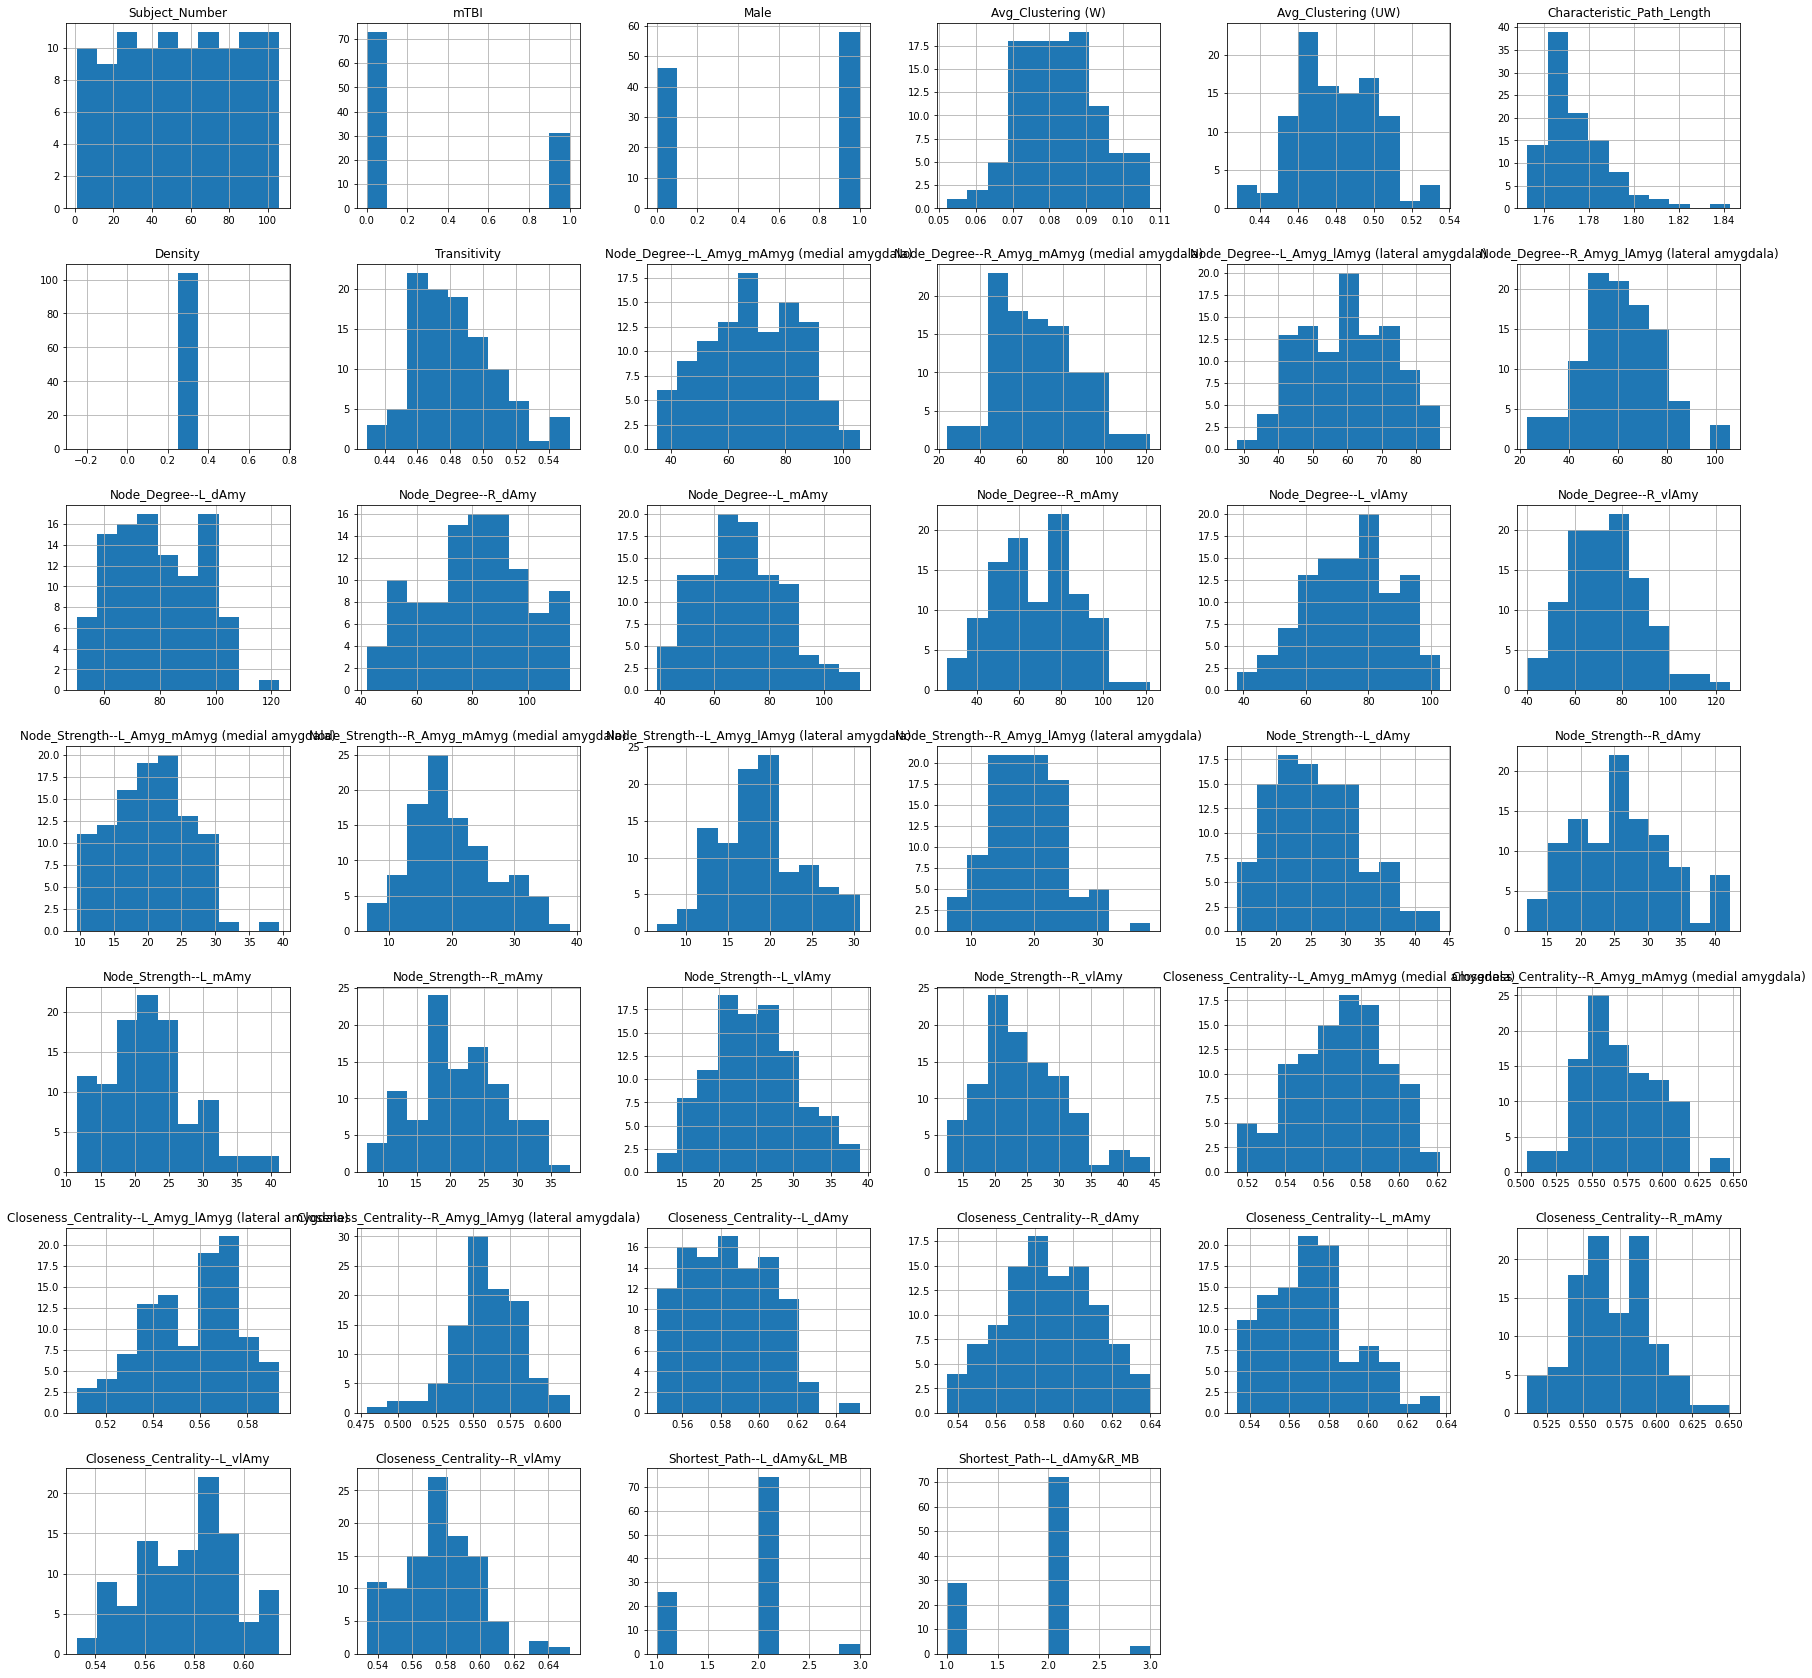

In [320]:
#make figure bigger
plt.rcParams['figure.figsize'] = 30, 30
all_data.hist(bins = 10)